In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import operator
from torch.nn import init
from torch import nn
import torch.nn.functional as F

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'


def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a,b): test(a,b,near)  
  
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"
  
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = Model(m, nh, 10)

In [0]:
pred = model(x_train)

In [0]:
F??

In [0]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim = True))).log() # why -1 and why keepdim?

In [0]:
test = torch.randn(5,10)

In [0]:
test,test.sum(0)

(tensor([[ 0.3796,  0.8264, -0.8497, -0.0303,  1.0123,  0.2223,  1.0420,  1.0414,
           1.6561, -0.1093],
         [-0.3439,  0.3155,  0.0568, -0.6805, -0.6028, -0.8371, -0.5300,  0.9267,
           0.5894, -1.1739],
         [ 0.0818, -0.9784,  0.6176,  0.3624,  0.7847, -0.3085,  0.8961,  0.5564,
           0.7844,  0.2580],
         [ 1.3042, -0.4559,  1.0494,  0.2993,  1.7560,  0.6555,  1.9412, -1.2190,
          -0.0827,  0.9786],
         [-0.6750, -0.9882, -0.1480, -0.5307, -0.5577, -0.5488, -0.2529,  0.2207,
          -0.5769, -2.3232]]),
 tensor([ 0.7466, -1.2805,  0.7261, -0.5798,  2.3925, -0.8165,  3.0964,  1.5262,
          2.3702, -2.3697]))

In [0]:
test.sum(0,keepdim = True)

tensor([[ 0.7466, -1.2805,  0.7261, -0.5798,  2.3925, -0.8165,  3.0964,  1.5262,
          2.3702, -2.3697]])

In [0]:
test.sum(-1),test.sum(-1,keepdim = True)

(tensor([ 5.1909, -2.2798,  3.0545,  6.2265, -6.3806]), tensor([[ 5.1909],
         [-2.2798],
         [ 3.0545],
         [ 6.2265],
         [-6.3806]]))

In [0]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$
But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style integer array indexing. Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [0]:
y_train[:3]

tensor([5, 0, 4])

In [0]:
sm_pred.shape

torch.Size([50000, 10])

Indexing ways

In [0]:
sm_pred[[1,2,3]]

tensor([[-2.2367, -2.2286, -2.1919, -2.6077, -2.2727, -2.1632, -2.5577, -2.1643,
         -2.2809, -2.4349],
        [-2.2286, -2.3475, -2.2372, -2.5221, -2.2497, -2.2005, -2.3702, -2.1699,
         -2.3387, -2.4147],
        [-2.1963, -2.2952, -2.3481, -2.5119, -2.2377, -2.1865, -2.4415, -2.1769,
         -2.2887, -2.4019]], grad_fn=<IndexBackward>)

In [0]:
sm_pred[[0,1,2],[5, 0, 4]]

tensor([-2.2266, -2.2367, -2.2497], grad_fn=<IndexBackward>)

In [0]:
def nll(input, target): return -input[range(target.shape[0]),target].mean()

In [0]:
loss = nll(sm_pred, y_train)

In [0]:
loss

tensor(2.3195, grad_fn=<NegBackward>)

Note that the formula

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$
gives a simplification when we compute the log softmax, which was previously defined as (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [0]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [0]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the LogSumExp trick. The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$
where a is the maximum of the $x_{j}$.

In [0]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [0]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [0]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [0]:
test_near(nll(log_softmax(pred), y_train), loss)

In [0]:
#PyTorch's implementation.
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [0]:
#In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy
test_near(F.cross_entropy(pred, y_train), loss)


Basic training loop
Basically the training loop repeats over the following steps:

1.get the output of the model on a batch of inputs

2.compare the output to the labels we have and compute a loss

3.calculate the gradients of the loss with respect to every parameter of the model

4.update said parameters with those gradients to make them a little bit better

In [0]:
loss_func = F.cross_entropy

In [0]:
temp = tensor([[0,1,0],[1,0,0],[1,0,0]]).float()
temp

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [0]:
torch.argmax(temp,dim=1),torch.argmax(temp,dim=0)

(tensor([1, 0, 0]), tensor([2, 0, 2]))

In [0]:
def accuracy(out, yb): return (torch.argmax(out,dim=1)==yb).float().mean()

In [0]:
bs = 64

xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.1614,  0.0266,  0.1104, -0.1878, -0.0250,  0.1070, -0.1843,  0.1994,
          0.0936, -0.0735], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [0]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3244, grad_fn=<NllLossBackward>)

In [0]:
accuracy(preds, yb)

tensor(0.1094)

In [0]:
lr = 0.1 
epochs = 1

In [0]:
n = x_train.shape[0]

In [0]:
nn.Linear??

In [0]:
for epoch in range(epochs):
  for batch in range((n-1)//bs +1):
    
    x_batch = x_train[batch*bs:(batch+1)*bs]
    y_batch = y_train[batch*bs:(batch+1)*bs]
    
    preds = model(x_batch)
    
    loss = loss_func(preds,y_batch)
    
    loss.backward()
    
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad*lr
          l.bias -= l.bias.grad*lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()

In [0]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2988, grad_fn=<NllLossBackward>), tensor(0.9219))

Using parameters and optim

Parameters

Use nn.Module.__setattr__ and move relu to functional

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m, nh, 10)

In [0]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [0]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [0]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2986, grad_fn=<NllLossBackward>), tensor(0.9219))

Behind the scenes, PyTorch overrides the __setattr__ function in nn.Module so that the submodules you define are properly registered as parameters of the model.

In [0]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.n = 3
        
    def __setattr__(self,k,v):
        if not k.startswith("_") and hasattr(v,'parameters'): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [0]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [0]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

**Registering modules**

We can use the original layers approach, but we have to register the modules

In [0]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [0]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = Model(layers)

In [0]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

**nn.ModuleList**

nn.ModuleList does this for us

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = SequentialModel(layers)

In [0]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [0]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2909, grad_fn=<NllLossBackward>), tensor(0.9219))

**nn.Sequential**

nn.Sequential is a convenient class which does the same as the above:

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [0]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3058, grad_fn=<NllLossBackward>), tensor(0.9219))

In [0]:
nn.Sequential??

In [0]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

**optim**

Let's replace our previous manually coded optimization step
:



```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```


    
and instead use just:



```
opt.step()
opt.zero_grad()
```

In [0]:
class Optimizer():
  
  def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
    
  def step(self):
    with torch.no_grad():
      for p in self.params: p -= p.grad*lr
        
  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()
    

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [0]:
opt = Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1438, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in optim.SGD (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [0]:
#export
from torch import optim

In [0]:
optim.SGD.step??

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [0]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3230, grad_fn=<NllLossBackward>)

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1529, grad_fn=<NllLossBackward>), tensor(1.))

In [0]:
assert acc>0.7

In [0]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i],self.y[i]

In [0]:
train_ds,valid_ds = Dataset(x_train,y_train), Dataset(x_valid,y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [0]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [0]:
model,opt = get_model()

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1424, grad_fn=<NllLossBackward>), tensor(1.))

**DataLoader**

Previously, our loop iterated over batches (xb, yb) like this:


```
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```
Let's make our loop much cleaner, using a data loader:


```
for xb,yb in train_dl:
```





In [0]:
class DataLoader():
  def __init__(self, ds, bs): self.ds, self.bs = ds,bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs] # note here yield is used

In [0]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [0]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

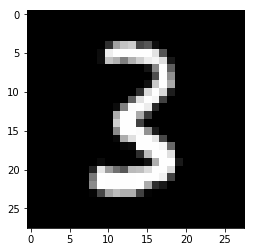

In [0]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [0]:
model,opt = get_model()

In [0]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [0]:
fit()

In [0]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2725, grad_fn=<NllLossBackward>), tensor(0.9531))

**Random sampling**

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [0]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [0]:
small_ds = Dataset(*train_ds[:10])

In [0]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [0]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([9, 2, 3]), tensor([1, 5, 8]), tensor([6, 0, 4]), tensor([7])]

In [0]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)
  
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [0]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [0]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

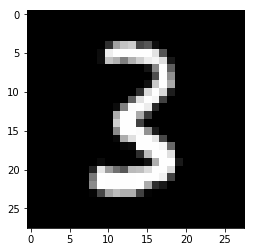

In [0]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(2)

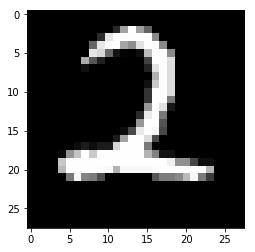

In [0]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(6)

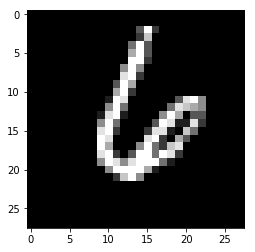

In [0]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [0]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.3714, grad_fn=<NllLossBackward>), tensor(0.9375))

**PyTorch DataLoader**

In [0]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [0]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3445, grad_fn=<NllLossBackward>), tensor(0.9219))

In [0]:
DataLoader??

In [0]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

PyTorch's defaults work fine for most things however:

In [0]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.3673, grad_fn=<NllLossBackward>), tensor(0.9062))

Note that PyTorch's DataLoader, if you pass num_workers, will use multiple threads to call your Dataset.



**Validation**

You always should also have a validation set, in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        
        with torch.no_grad():
          # we calculate loss and accuracy on valid set which is displayed as metric after each epoch
          tot_loss, tot_acc = 0.,0.
          for xb, yb in valid_dl:  
            pred = model(xb)
            tot_loss += loss_func(pred, yb)
            tot_acc += accuracy(pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        
    return tot_loss/nv, tot_acc/nv
         

Question: Are these validation results correct if batch size varies?

get_dls returns dataloaders for the training and validation sets:

In [0]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [0]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2954) tensor(0.9129)
1 tensor(0.2248) tensor(0.9362)
2 tensor(0.1870) tensor(0.9469)
3 tensor(0.1571) tensor(0.9585)
4 tensor(0.1383) tensor(0.9634)


In [0]:
assert acc>0.9


# DataBunch/Learner

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

Factor out the connected pieces of info out of the fit() argument list

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Let's replace it with something that looks like this:

fit(1, learn)

This will allow us to tweak what's happening inside the training loop in other places of the code because the Learner object will be mutable, so changing any of its attribute elsewhere will be seen in our training loop

In [0]:
DataLoader??

In [0]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:
loss,acc = fit(1, learn)

0 tensor(0.3771) tensor(0.8727)


# CallbackHandler

This was our training loop (without validation) from the previous notebook, with the inner loop contents factored out:


```
def one_batch(xb,yb):
    pred = model(xb)
    loss = loss_func(pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

def fit():
    for epoch in range(epochs):
        for b in train_dl: one_batch(*b)
```

Add callbacks so we can remove complexity from loop, and make it flexible:

In [0]:
def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb,yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()

def all_batches(dl, cb):
    for xb,yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop(): return

def fit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

In [0]:
class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True